In [189]:
from langgraph.graph import StateGraph,START,END
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langchain.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from typing import TypedDict
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_ollama import OllamaEmbeddings
from langchain.pydantic_v1 import BaseModel,Field
from langchain.vectorstores.chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
import os

load_dotenv()

True

In [190]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [191]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [192]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [193]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5c660ad5-10c7-4c86-b910-ab37afae3716-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [194]:
class state(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question : str
    generation: str
    web_search: str
    document : list[str]

In [195]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = []
for doc in docs:
    for item in doc:
        docs_list.append(item)
        
text_spliter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=200,chunk_overlap=50
)

doc_split = text_spliter.split_documents(docs_list)

vectore_store = Chroma(
    collection_name="website-data",
    embedding_function=embeddings
)
vectore_store.add_documents(doc_split)

retriever = vectore_store.as_retriever()

In [197]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [198]:
question = "tell me about the agent memory."
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [199]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
     
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm 

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document
from langchain_core.output_parsers import StrOutputParser     
     
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "you are a Ai assistant give meaningfull and short answer on user question"),
        (
            "human",
            "Here is the initial question: \n\n {question} ",
        ),
    ]
)

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

chain = prompt | llm | StrOutputParser()

question = "tell me about agent"

ans = chain.invoke({'question':question})
 
print(ans)

In [200]:
question_rewriter.invoke({'question':question}).content

'What is agent memory in artificial intelligence?'

In [201]:
def retrieve(state):
    question = state['question']
    
    document = retriever.get_relevant_documents(question)
    
    return{'document':document,'question':question}

In [202]:
def generat(state):
    document = state['document']
    question = state['question']
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm | StrOutputParser()
    
    response = rag_chain.invoke({"context":document,"question":question})
    
    return {"document":document,"question":question,'generation':response}

In [203]:
def grad_document(state):
    question = state['question']
    document = state['document']
    
    web_search = 'no'
    
    filter_doc = []
    
    for d in document:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
            )
        
        grad = score.binary_score
        if grad == 'yes':
            filter_doc.append(d)
        else:
            web_search = "yes"
            continue
    
    return {'document':filter_doc,'question':question,'web_search':web_search}

In [204]:
# document = retriever.get_relevant_documents('tell me about tajmahal')

In [205]:
# question = "tell me about tajmahal"

In [206]:

# web_search = 'no'

# filter_doc = []

# for d in document:
#     score = retrieval_grader.invoke(
#         {"question": question, "document": d.page_content}
#         )
    
#     grad = score.binary_score
#     if grad == 'yes':
#         filter_doc.append(d)
#     else:
#         web_search = "yes"
#         continue

# print(filter_doc)
# print(web_search)

In [217]:
def rewriter(state):
    question = state['question']
    document = state['document']
    
    system = """You a question re-writer that converts an input question to a better version that is optimized \n 
        for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
        
        
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )

    question_rewriter = re_write_prompt | llm | StrOutputParser()
    
    response = question_rewriter.invoke({'question':question})
    
    return {'question':response,'document':document}

In [208]:
def web_searches(state):
    question = state['question']
    document = state['document']
    
    tavily = TavilySearchResults()
    
    doc = tavily.invoke(question)
    
    web_search = "/n".join([d['content'] for d in doc])
    
    web_result = Document(page_content=web_search)
    
    document.append(web_result)
    
    return {'document':document,'question':question}

In [209]:
# question = "what is agent"
# tavily = TavilySearchResults()
# doc = tavily.invoke(question)
# web_search = "/n".join([d['content'] for d in doc])
# web_results = Document(page_content=web_search)
# web_results

In [210]:
def decide_to_generate(state):
    question = state['question']
    document = state['document']
    web_search = state['web_search']
    
    if web_search=='yes':
        return "transform_query"
    else:
        return "generate"

In [218]:
workflow = StateGraph(state)
workflow.add_node('retriver',retrieve)
workflow.add_node('generator',generat)
workflow.add_node("grad_document",grad_document)
workflow.add_node("rewriter",rewriter)
workflow.add_node("tool",web_searches)

In [219]:
workflow.add_edge(START,'retriver')
workflow.add_edge("retriver",'grad_document')
workflow.add_conditional_edges("grad_document", decide_to_generate, {"transform_query": "rewriter","generate": "generator",}),
workflow.add_edge("rewriter","tool")
workflow.add_edge("tool",'generator')
workflow.add_edge('generator',END)
app = workflow.compile()

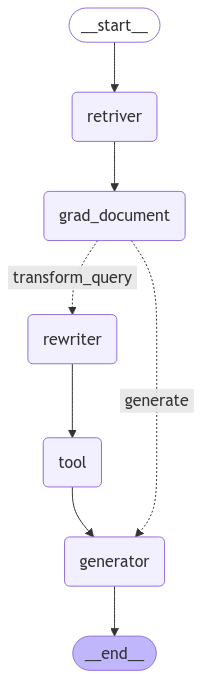

In [213]:
app

In [ ]:
from pprint import pprint

# Run
inputs = {"question": "tell me about the agent memory."}

In [228]:
result = app.invoke(inputs)
print(result['generation'])

c:\Users\ADMIN\anaconda3\envs\jay\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The provided text contains examples of input statements and questions, but it does not offer an answer to a question about improving a statement because no statement needing improvement was provided.  The text focuses on input statements and their formatting.


In [226]:
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'retriver':
---
{'document': [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-conte

c:\Users\ADMIN\anaconda3\envs\jay\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Output from node 'generator':
---
{'document': [Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-cont